In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')
plt.rcParams["font.size"] = 18
np.random.seed(123)

In [3]:
df = pd.read_csv('./data/ch6_p1.csv', header=None)
df.columns = ['price']

In [4]:
df

,price
0,76230
1,73550
2,80750
3,71500
4,75420
5,74840
6,71580
7,76920
8,68450
9,76990


In [5]:
stan_model = """
    data{
        int N;
        real X[N];
    }
    
    parameters{
        real mu;
        real<lower=0> sigma;
    }
    
    model{
        for(n in 1:N){
            X[n] ~ normal(mu, sigma);
        }
    }
    
    generated quantities{
        real<lower=0, upper=1> mu_over1;
        real<lower=0, upper=1> mu_over2;
        
        mu_over1 <- step(mu - 70000);
        mu_over2 <- step(mu - 75000);
    }
"""

In [6]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_daa56690e0251fe9b2bbf86de2eb841f NOW.


In [7]:
stan_data = {"N": df.shape[0], "X": df['price']}

In [8]:
fit = sm.sampling(data=stan_data, iter=11000, warmup=1000, chains=3, seed=1234)

In [9]:
fit

Inference for Stan model: anon_model_daa56690e0251fe9b2bbf86de2eb841f.
3 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=30000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu        7.4e4   12.47 1512.1  7.1e4  7.3e4  7.4e4  7.5e4  7.7e4  14710    1.0
sigma    5066.3   11.54 1298.6 3261.2 4165.1 4833.9 5700.5 8229.6  12674    1.0
mu_over1   0.99  9.6e-4    0.1    1.0    1.0    1.0    1.0    1.0  10601    1.0
mu_over2   0.21  3.0e-3   0.41    0.0    0.0    0.0    0.0    1.0  18661    1.0
lp__     -98.99    0.01   1.11 -101.9 -99.41 -98.65 -98.21 -97.92   9566    1.0

Samples were drawn using NUTS at Mon Aug 13 21:35:10 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [39]:
arr = fit.get_posterior_mean()
print("EAP: {0:.1f}".format(np.average(arr[0])))
print("70000円を超える確率: {0:.1%}".format(np.average(arr[2])))
print("75000円を超える確率: {0:.1%}".format(np.average(arr[3])))

EAP: 73860.3
70000円を超える確率: 99.0%
75000円を超える確率: 21.0%


In [64]:
data = fit.summary()
df_summary = pd.DataFrame(data['summary'], columns=data['summary_colnames'], index=data['summary_rownames'])
df_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,73860.258197,12.467496,1512.117580,70857.451586,72928.198819,73869.132646,74814.996424,76826.527835,14710.0,1.000357
sigma,5066.335879,11.535062,1298.604146,3261.214590,4165.129807,4833.931961,5700.578976,8229.688832,12674.0,1.000299
mu_over1,0.990233,0.000955,0.098344,1.000000,1.000000,1.000000,1.000000,1.000000,10601.0,1.000370
mu_over2,0.209767,0.002980,0.407149,0.000000,0.000000,0.000000,0.000000,1.000000,18661.0,1.000203
lp__,-98.987796,0.011305,1.105742,-101.979728,-99.410738,-98.649933,-98.206792,-97.917715,9566.0,1.000123


/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


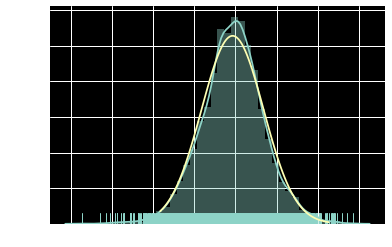

In [66]:
la = fit.extract(permuted=True) # サンプル列
names = fit.model_pars #パラメーター名
from scipy.stats import norm, gamma
u = la['mu'].mean()
s = la['mu'].std()
sns.distplot(la['mu'][:5000], kde=True,rug=True, norm_hist=False, bins=40)
x = np.linspace(norm.ppf(0.01, loc=u, scale=s), norm.ppf(0.999, loc=u, scale=s), 100)
plt.plot(x, norm.pdf(x=x, loc=u, scale=s))